# Wikipedia Mining

- Identify 5 categories of pages on wikipedia, for each category choose 300 items.

With a python script:
- load the pages,
- preprocess them (*)
- insert them in a dataframe (save the dataframe in a CSV file and use it later for subsequent loads)
- Create statistics (frequency and word length, for example) on the pages and show them with different types of visualization
- Calculate the distance between pages in the same category and between different categories
- Classify the pages, using the categories as labels.
- Check the wikipedia categorization or any deviations with a clustering method and in this case analyze the probable causes

In [1]:
# download the nltk libraries
import nltk
from nltk import word_tokenize, download
from nltk.corpus import stopwords
# import yellowbrick
from yellowbrick.text import FreqDistVisualizer
from nltk.stem.porter import * 

download("punkt")  
download("stopwords")  
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import urllib.request  
from bs4 import BeautifulSoup  

# import the sklearn libraries
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn import svm
import scipy.stats

import copy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from __future__ import unicode_literals
import sys
import os
import random
import re
import string

from gensim.models import Word2Vec
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ewieh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 5 Categories 

1. Human activities 
2. Health
3. Physical sciences 
4. Religion 
5. Geography


## Load the pages for the 5 categories

In [2]:
# all categories
categories = ["Human-activities","Health", "Physical-sciences", "Religion", "Geography"]

# URLs of the categories
url_human_activities = "https://petscan.wmflabs.org/?sitelinks_yes=&larger=&regexp_filter=&labels_yes=&smaller=&outlinks_any=&search_wiki=&pagepile=&labels_any=&edits%5Bbots%5D=both&min_redlink_count=1&show_redirects=both&templates_yes=&wikidata_item=no&cb_labels_no_l=1&project=wikipedia&ores_prediction=any&manual_list_wiki=&labels_no=&links_to_no=&search_max_results=500&subpage_filter=either&maxlinks=&sparql=&cb_labels_any_l=1&categories=Human+activities&namespace_conversion=keep&active_tab=tab_categories&show_disambiguation_pages=both&ores_type=any&ns%5B0%5D=1&common_wiki=auto&cb_labels_yes_l=1&outlinks_no=&show_soft_redirects=both&language=en&depth=1&wikidata_source_sites=&page_image=any&referrer_name=&langs_labels_any=&interface_language=en&max_sitelink_count=&doit="
url_health = "https://petscan.wmflabs.org/?show_soft_redirects=both&sitelinks_no=&search_filter=&interface_language=en&sitelinks_any=&regexp_filter=&cb_labels_yes_l=1&project=wikipedia&labels_no=&templates_any=&after=&search_max_results=500&format=html&referrer_name=&ores_prob_to=&manual_list=&outlinks_yes=&wikidata_label_language=&search_wiki=&show_disambiguation_pages=both&cb_labels_any_l=1&combination=subset&ores_type=any&categories=Health&links_to_all=&max_age=&ores_prediction=any&search_query=&cb_labels_no_l=1&sortorder=ascending&sortby=none&common_wiki_other=&minlinks=&sparql=&labels_any=&outlinks_no=&links_to_no=&since_rev0=&ns%5B0%5D=1&depth=1&labels_yes=&language=en&doit="
url_physical_sciences = "https://petscan.wmflabs.org/?outlinks_any=&links_to_all=&search_max_results=500&common_wiki_other=&project=wikipedia&ores_prediction=any&manual_list=&cb_labels_yes_l=1&subpage_filter=either&templates_yes=&langs_labels_no=&regexp_filter=&since_rev0=&outlinks_yes=&language=en&cb_labels_no_l=1&sparql=&ns%5B0%5D=1&depth=1&cb_labels_any_l=1&categories=Physical+sciences&wikidata_source_sites=&interface_language=en&max_sitelink_count=&doit="
url_religion = "https://petscan.wmflabs.org/?outlinks_yes=&langs_labels_yes=&search_wiki=&labels_any=&interface_language=en&manual_list=&referrer_url=&depth=1&ores_prob_from=&smaller=&before=&show_redirects=both&ns%5B0%5D=1&sortby=none&project=wikipedia&search_max_results=500&categories=religion&source_combination=&negcats=&max_age=&edits%5Bbots%5D=both&wikidata_source_sites=&common_wiki=auto&maxlinks=&links_to_no=&cb_labels_yes_l=1&search_filter=&output_limit=&min_sitelink_count=&search_query=&active_tab=tab_categories&namespace_conversion=keep&ores_type=any&wikidata_prop_item_use=&cb_labels_no_l=1&min_redlink_count=1&language=en&format=html&cb_labels_any_l=1&minlinks=&edits%5Bflagged%5D=both&doit="
url_geography = "https://petscan.wmflabs.org/?cb_labels_yes_l=1&referrer_name=&manual_list_wiki=&wikidata_prop_item_use=&search_filter=&larger=&templates_any=&wpiu=any&wikidata_source_sites=&show_disambiguation_pages=both&outlinks_no=&after=&minlinks=&ores_prediction=any&sitelinks_no=&referrer_url=&common_wiki_other=&ores_prob_from=&common_wiki=auto&categories=geography&cb_labels_any_l=1&since_rev0=&wikidata_label_language=&cb_labels_no_l=1&pagepile=&interface_language=en&ns%5B0%5D=1&maxlinks=&labels_yes=&depth=1&format=html&language=en&links_to_no=&smaller=&manual_list=&project=wikipedia&wikidata_item=no&search_query=&combination=subset&search_max_results=500&source_combination=&min_redlink_count=1&doit="

list_urls = [url_human_activities,url_health,url_physical_sciences, url_religion, url_geography]

## Extract the article names from the pages

In [3]:
# Get all the names of the articles for each category
list_raw_tokens = []
for i in list_urls:
    # read the html text only, at given url
    html_doc = urllib.request.urlopen(i).read().decode('utf8')

    # Use BeautifulSoup to parse HTML (build the DOM) and extract text sections from it
    soup = BeautifulSoup(html_doc, 'html.parser')

    # Strip down from DOM unwanted sections (script and style tags)
    for unwanted in soup(["script", "style"]):
        unwanted.extract()  # remove script and style contents from html

    text = soup.get_text()  # extract text from HTML

    K = " "

    for ele in text:
        if ele.isdigit():
            text = text.replace(ele, K)

    lines = []
    for line in text.splitlines():  # for each line into the document
        stripped_line = line.strip()  # remove heading and trailing whitespaces

        # stop at Notes or Citation section of wikipedia pages
        if stripped_line.startswith("Notes") or stripped_line.startswith("Citation"):
            break
        elif stripped_line != "":
            lines.append(stripped_line)


    text = "\n".join(lines)  # rebuild text with blank lines and unwanted section stripped down
    #raw_tokens = word_tokenize(text)
    list_raw_tokens.append(word_tokenize(text))


## Load the wikipedia pages with the article names

In [4]:
# This may take a while
# Get the text of the articles for each category
data = []
category = []
articles = []
i = 0
count = 0
# for each category
for k in range(0, 5):
    while count < 300:
        i += 1
        if list_raw_tokens[k][i] == "Article":
            count += 1

            # get the whole article names
            for j in range(1, 10):
                if list_raw_tokens[k][i+j] != "Article":
                    articles.append(str(list_raw_tokens[k][i+j]))
                else: break

            # get article text
            try:
                # get the url of the article
                url2 = "https://en.wikipedia.org/wiki/" + '_'.join(str(e) for e in articles)
                # read the html text only, at given url
                html_doc = urllib.request.urlopen(url2).read().decode("utf8", "ignore")
                soup = BeautifulSoup(html_doc, 'html.parser')
            except:
                # if the article is not found, skip it
                articles.clear()
                count -= 1
                continue

            # Strip down from unwanted sections 
            for unwanted in soup(["script", "style"]):
                unwanted.extract()  

            # extract text from HTML
            text = soup.get_text() 

            # remove heading and trailing whitespaces
            lines = []
            for line in text.splitlines():  
                stripped_line = line.strip()

                # stop at Notes or Citation section of wikipedia pages
                if stripped_line.startswith("Notes") or stripped_line.startswith("Citation"):
                    break
                elif stripped_line != "":
                    lines.append(stripped_line)

            # rebuild text 
            text = "\n".join(lines)  
            category.append(text)
            articles.clear()

    # get the text for each category
    data.append(copy.deepcopy(category))

    # reset parameters
    category.clear()
    count = 0
    i = 0

## Create a dataframe

In [5]:
# Create the pandas DataFrame
df = pd.DataFrame(data, categories)
# Transpose the DataFrame
df = df.transpose()
# display the DataFrame
df

,Human-activities,Health,Physical-sciences,Religion,Geography
0,"Art - Wikipedia\nArt\nFrom Wikipedia, the free...",Beryllium - Wikipedia\nBeryllium\nFrom Wikiped...,"Atom - Wikipedia\nAtom\nFrom Wikipedia, the fr...",Afterlife - Wikipedia\nAfterlife\nFrom Wikiped...,List of explorations - Wikipedia\nList of expl...
1,Abiotic stress - Wikipedia\nAbiotic stress\nFr...,"Condom - Wikipedia\nCondom\nFrom Wikipedia, th...","Alloy - Wikipedia\nAlloy\nFrom Wikipedia, the ...","Animism - Wikipedia\nAnimism\nFrom Wikipedia, ...","Furlong - Wikipedia\nFurlong\nFrom Wikipedia, ..."
2,Affection - Wikipedia\nAffection\nFrom Wikiped...,Chlorine - Wikipedia\nChlorine\nFrom Wikipedia...,Allotropy - Wikipedia\nAllotropy\nFrom Wikiped...,Anthroposophy - Wikipedia\nAnthroposophy\nFrom...,Far East - Wikipedia\nFar East\nFrom Wikipedia...
3,"Barter - Wikipedia\nBarter\nFrom Wikipedia, th...",Chromium - Wikipedia\nChromium\nFrom Wikipedia...,Analytical chemistry - Wikipedia\nAnalytical c...,Absolute Infinite - Wikipedia\nAbsolute Infini...,Greenwich Mean Time - Wikipedia\nGreenwich Mea...
4,Communication - Wikipedia\nCommunication\nFrom...,"Cadmium - Wikipedia\nCadmium\nFrom Wikipedia, ...",Chemistry - Wikipedia\nChemistry\nFrom Wikiped...,Casuistry - Wikipedia\nCasuistry\nFrom Wikiped...,Longitude - Wikipedia\nLongitude\nFrom Wikiped...
...,...,...,...,...,...
295,Position line - Wikipedia\nPosition line\nFrom...,Alcohol education - Wikipedia\nAlcohol educati...,Incipient wetness impregnation - Wikipedia\nIn...,Religious fanaticism - Wikipedia\nReligious fa...,Sustainable city - Wikipedia\nSustainable city...
296,Position circle - Wikipedia\nPosition circle\n...,Alcohol and weight - Wikipedia\nAlcohol and we...,Chemical technologist - Wikipedia\nChemical te...,Grawemeyer Award - Wikipedia\nGrawemeyer Award...,Public open space - Wikipedia\nPublic open spa...
297,Sector light - Wikipedia\nSector light\nFrom W...,TeenScreen - Wikipedia\nTeenScreen\nFrom Wikip...,Congruent melting - Wikipedia\nCongruent melti...,Vow of obedience - Wikipedia\nVow of obedience...,List of countries by northernmost point - Wiki...
298,Light characteristic - Wikipedia\nLight charac...,Guideline execution engine - Wikipedia\nGuidel...,Marsquake - Wikipedia\nMarsquake\nFrom Wikiped...,Criticism of Christianity - Wikipedia\nCritici...,Western Australian borders - Wikipedia\nWester...


## Save the dataframe in a CSV file

In [6]:
# Save the DataFrame to a csv file
files = [f for f in os.listdir('C:/Users/ewieh/Documents/Semester 5/Massive_Data/Wikipedia_Project')]
if not 'Wikipedia_Mining_Data.csv' in files: df.to_csv('Wikipedia_Mining_Data.csv')

# Start from here if you have already saved the dataframe

In [7]:
# open file Wikipedia_Mining.csv as a dataframe
df_raw = pd.read_csv('Wikipedia_Mining_Data.csv', sep=',', header=None)
categories = ["Human-activities","Health", "Physical-sciences", "Religion", "Geography"]

## Preprocess the dataframe

In [8]:
# drop first column because it is empty
df = df_raw.drop(df_raw.columns[0], axis=1)

# rename the columns
df.columns = categories

# drop the first row because it is redundant
df = df.drop(df.index[0])

# preprocess the articles by removing punctuation, numbers, and special characters
df = df.replace(r'[^a-zA-Z ]+', ' ', regex=True)

# convert all characters to lowercase
df = df.apply(lambda x: x.astype(str).str.lower())

# lemmatize the words
lemmatizer = WordNetLemmatizer()
df = df.apply(lambda x: x.astype(str).str.split().apply(lambda x: [lemmatizer.lemmatize(item) for item in x]).str.join(' '))

# remove stop words
stop_words = set(stopwords.words('english'))
stop_words.add('wikipedia')
df = df.apply(lambda x: x.astype(str).str.split().apply(lambda x: [item for item in x if item not in stop_words]).str.join(' '))

df

,Human-activities,Health,Physical-sciences,Religion,Geography
1,art art free encyclopedia jump navigation jump...,beryllium beryllium free encyclopedia jump nav...,atom atom free encyclopedia jump navigation ju...,afterlife afterlife free encyclopedia jump nav...,list exploration list exploration free encyclo...
2,abiotic stress abiotic stress free encyclopedi...,condom condom free encyclopedia jump navigatio...,alloy alloy free encyclopedia jump navigation ...,animism animism free encyclopedia jump navigat...,furlong furlong free encyclopedia jump navigat...
3,affection affection free encyclopedia jump nav...,chlorine chlorine free encyclopedia jump navig...,allotropy allotropy free encyclopedia jump nav...,anthroposophy anthroposophy free encyclopedia ...,far east far east free encyclopedia jump navig...
4,barter barter free encyclopedia jump navigatio...,chromium chromium free encyclopedia jump navig...,analytical chemistry analytical chemistry free...,absolute infinite absolute infinite free encyc...,greenwich mean time greenwich mean time free e...
5,communication communication free encyclopedia ...,cadmium cadmium free encyclopedia jump navigat...,chemistry chemistry free encyclopedia jump nav...,casuistry casuistry free encyclopedia jump nav...,longitude longitude free encyclopedia jump nav...
...,...,...,...,...,...
296,position line position line free encyclopedia ...,condom fatigue condom fatigue free encyclopedi...,incipient wetness impregnation incipient wetne...,numinous numinous free encyclopedia jump navig...,list country northernmost point list country n...
297,position circle position circle free encyclope...,list r phrase list r phrase free encyclopedia ...,chemical technologist chemical technologist fr...,holy science holy science free encyclopedia ju...,western australian border western australian b...
298,sector light sector light free encyclopedia ju...,list phrase list phrase free encyclopedia jump...,congruent melting congruent melting free encyc...,spiritual intelligence spiritual intelligence ...,krasnoyarsk time krasnoyarsk time free encyclo...
299,light characteristic light characteristic free...,dry sex dry sex free encyclopedia jump navigat...,marsquake marsquake free encyclopedia jump nav...,blackfriar road blackfriar road free encyclope...,list sovereign state dependent territory list ...


## Create statistics on the pages
### (frequency and word length, for example) 

In [9]:
# tokenize the words
df_stats = df.apply(lambda x: x.astype(str).str.split()) 

# calculacte the number of words in each article and store them in a new column called "word_count" for each category
for i in categories:
    df_stats[i + '_word_count'] = df_stats[i].apply(lambda x: len(x))

# calculate the number of unique words in each article and store them in a new column called "unique_word_count" for each category
for i in categories:
    df_stats[i + '_unique_word_count'] = df_stats[i].apply(lambda x: len(set(x)))

# calculate the frequency of each word in each article and store them in a new column called "word_frequency" for each category
for i in categories:
    df_stats[i + '_word_frequency'] = df_stats[i].apply(lambda x: Counter(x))

# calculate the lenght of each word in each article and store them in a new column called "word_lenght" for each category
for i in categories:
    df_stats[i + '_word_length'] = df_stats[i].apply(lambda x: [len(word) for word in x])

# calculate the average lenght of each word in each article and store them in a new column called "average_word_lenght" for each category
for i in categories:
    df_stats[i + '_average_word_length'] = df_stats[i + '_word_length'].apply(lambda x: sum(x)/len(x))

# calculate the most common words in each article and store them in a new column called "word_lenght" for each category
for i in categories:
    df_stats[i + '_most_common_words'] = df_stats[i].apply(lambda x: Counter(x).most_common(10))

# display the DataFrame
df_stats

,Human-activities,Health,Physical-sciences,Religion,Geography,Human-activities_word_count,Health_word_count,Physical-sciences_word_count,Religion_word_count,Geography_word_count,...,Human-activities_average_word_length,Health_average_word_length,Physical-sciences_average_word_length,Religion_average_word_length,Geography_average_word_length,Human-activities_most_common_words,Health_most_common_words,Physical-sciences_most_common_words,Religion_most_common_words,Geography_most_common_words
1,"[art, art, free, encyclopedia, jump, navigatio...","[beryllium, beryllium, free, encyclopedia, jum...","[atom, atom, free, encyclopedia, jump, navigat...","[afterlife, afterlife, free, encyclopedia, jum...","[list, exploration, list, exploration, free, e...",5382,6893,5325,7165,567,...,6.538833,6.341651,6.479812,6.385764,6.386243,"[(art, 331), (work, 57), (artist, 37), (centur...","[(beryllium, 308), (archived, 68), (original, ...","[(atom, 176), (electron, 139), (nucleus, 97), ...","[(soul, 99), (death, 74), (afterlife, 69), (li...","[(america, 12), (exploration, 10), (north, 10)..."
2,"[abiotic, stress, abiotic, stress, free, encyc...","[condom, condom, free, encyclopedia, jump, nav...","[alloy, alloy, free, encyclopedia, jump, navig...","[animism, animism, free, encyclopedia, jump, n...","[furlong, furlong, free, encyclopedia, jump, n...",2938,8970,3648,7054,1611,...,6.717835,6.504571,6.493969,6.820386,5.947858,"[(plant, 101), (stress, 94), (abiotic, 56), (s...","[(condom, 496), (use, 126), (archived, 111), (...","[(alloy, 128), (steel, 91), (iron, 73), (metal...","[(animism, 112), (religion, 80), (p, 66), (har...","[(furlong, 60), (foot, 46), (unit, 31), (mile,..."
3,"[affection, affection, free, encyclopedia, jum...","[chlorine, chlorine, free, encyclopedia, jump,...","[allotropy, allotropy, free, encyclopedia, jum...","[anthroposophy, anthroposophy, free, encyclope...","[far, east, far, east, free, encyclopedia, jum...",1200,9307,1083,7112,2293,...,7.321667,6.480606,6.479224,6.982565,6.761012,"[(affection, 38), (emotion, 15), (love, 11), (...","[(chlorine, 287), (chloride, 112), (cl, 109), ...","[(allotrope, 32), (form, 27), (element, 26), (...","[(steiner, 175), (spiritual, 87), (anthroposop...","[(east, 91), (asia, 54), (far, 53), (language,..."
4,"[barter, barter, free, encyclopedia, jump, nav...","[chromium, chromium, free, encyclopedia, jump,...","[analytical, chemistry, analytical, chemistry,...","[absolute, infinite, absolute, infinite, free,...","[greenwich, mean, time, greenwich, mean, time,...",3795,4825,3204,425,1171,...,6.663768,6.452435,7.274969,6.616471,6.003416,"[(barter, 109), (exchange, 69), (trade, 40), (...","[(chromium, 295), (cr, 72), (iii, 50), (used, ...","[(chemistry, 104), (analysis, 64), (analytical...","[(set, 18), (number, 12), (absolute, 8), (infi...","[(time, 122), (greenwich, 41), (gmt, 36), (mea..."
5,"[communication, communication, free, encyclope...","[cadmium, cadmium, free, encyclopedia, jump, n...","[chemistry, chemistry, free, encyclopedia, jum...","[casuistry, casuistry, free, encyclopedia, jum...","[longitude, longitude, free, encyclopedia, jum...",6244,5178,6294,2621,3515,...,7.301249,6.170722,6.864474,6.571156,6.610811,"[(communication, 328), (message, 59), (model, ...","[(cadmium, 274), (cd, 51), (metal, 44), (doi, ...","[(chemistry, 207), (chemical, 164), (substance...","[(casuistry, 87), (ethic, 76), (doi, 53), (mor...","[(time, 107), (longitude, 90), (latitude, 32),..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,"[position, line, position, line, free, encyclo...","[condom, fatigue, condom, fatigue, free, encyc...","[incipient, wetness, impregnation, incipient, ...","[numinous, numinous, free, encyclopedia, jump,...","[list, country, northernmost, point, list, cou...",253,777,234,1300,1403,...,6.988142,5.976834,7.299145,6.555385,5.461155,"[(line, 16), (position, 10), (article, 6), (na...","[(condom, 44), (fatigue, 22), (men, 22), (use,...","

## Show them with different types of visualization

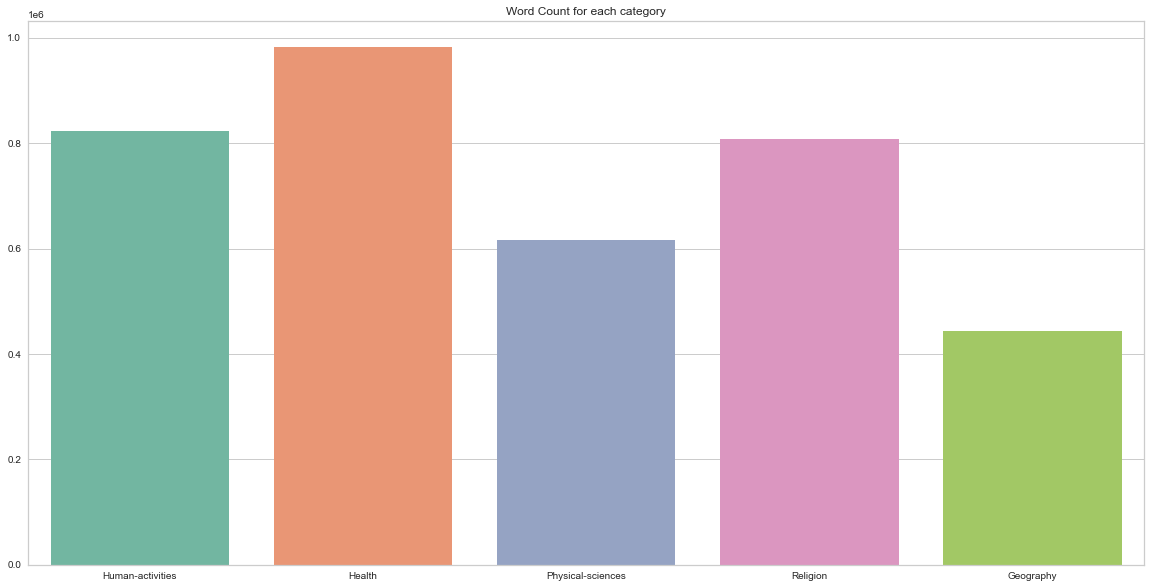

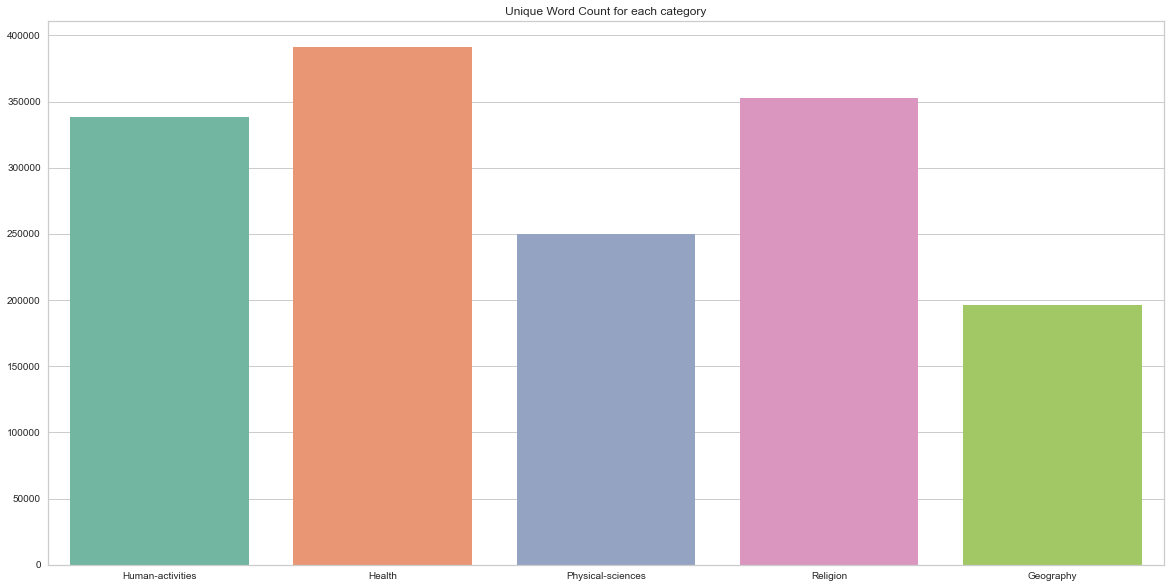

<AxesSubplot:title={'center':'Unique Word Count for each category'}, ylabel='Frequency'>

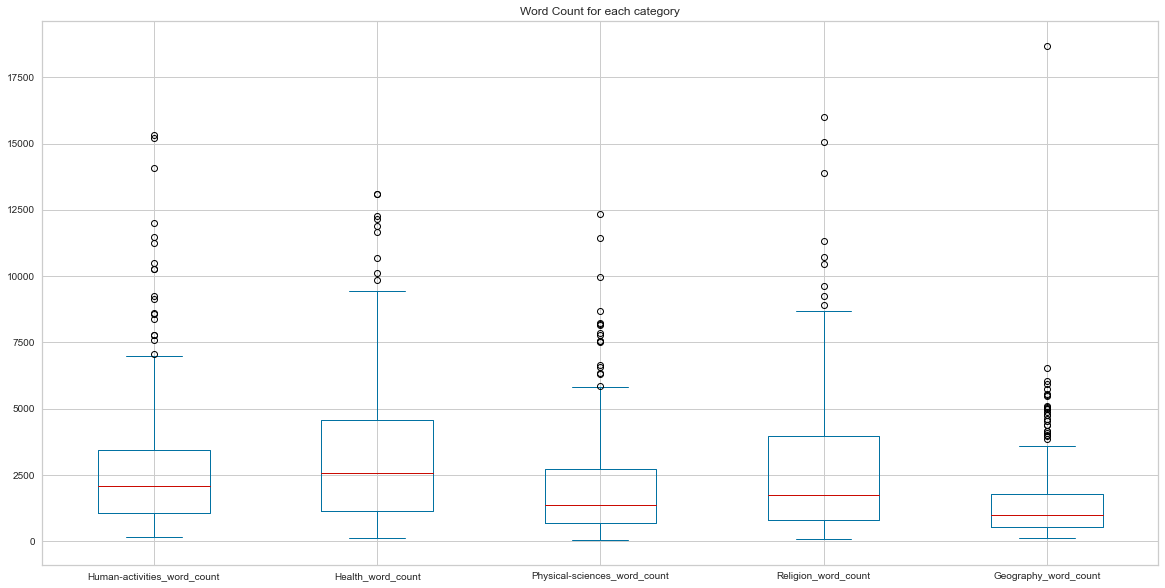

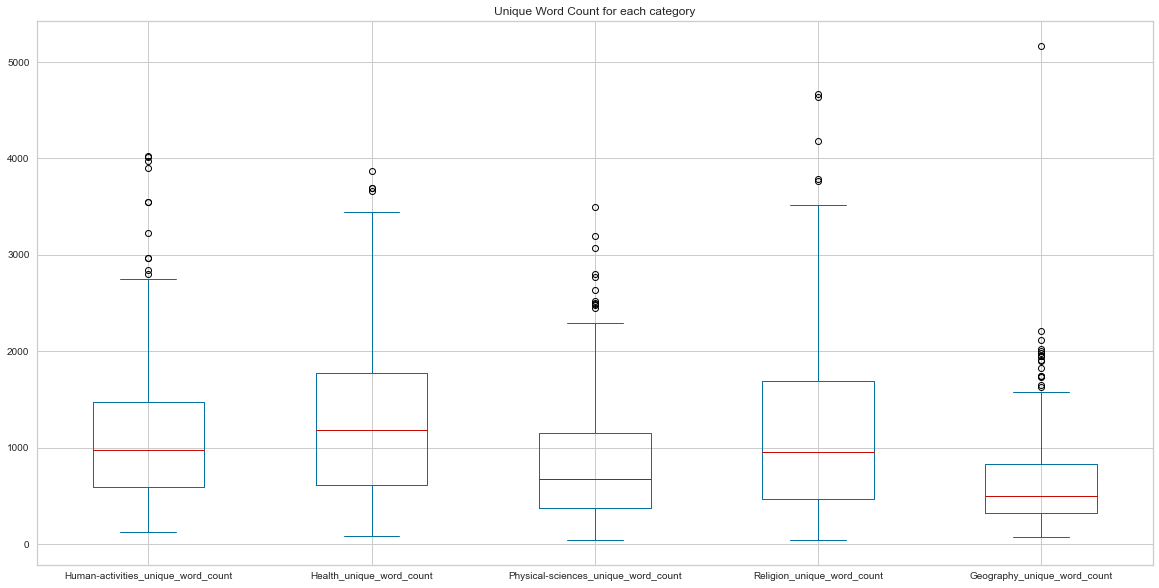

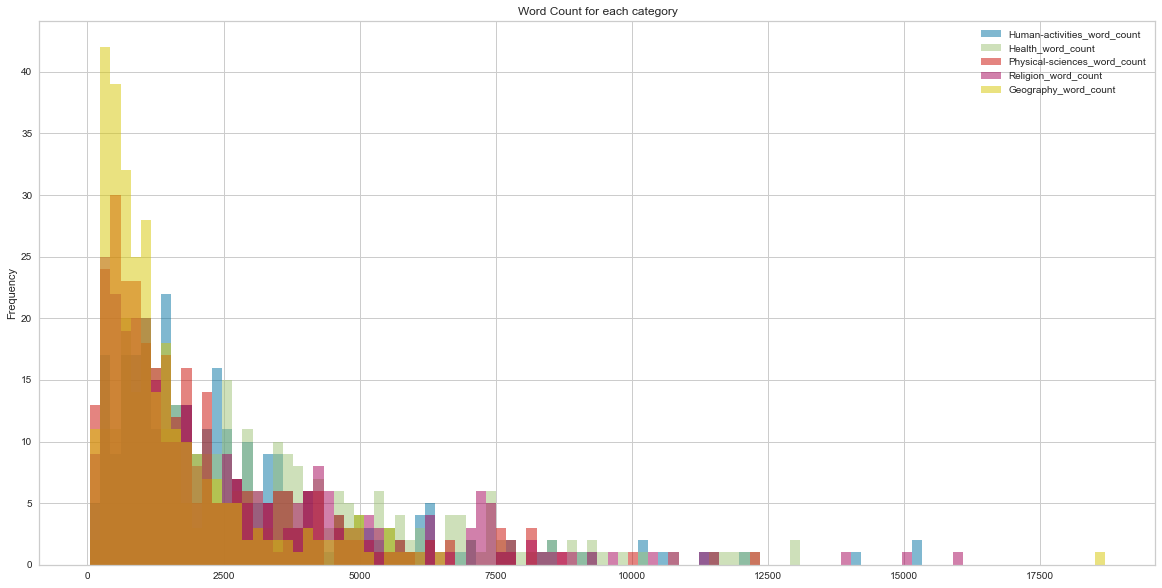

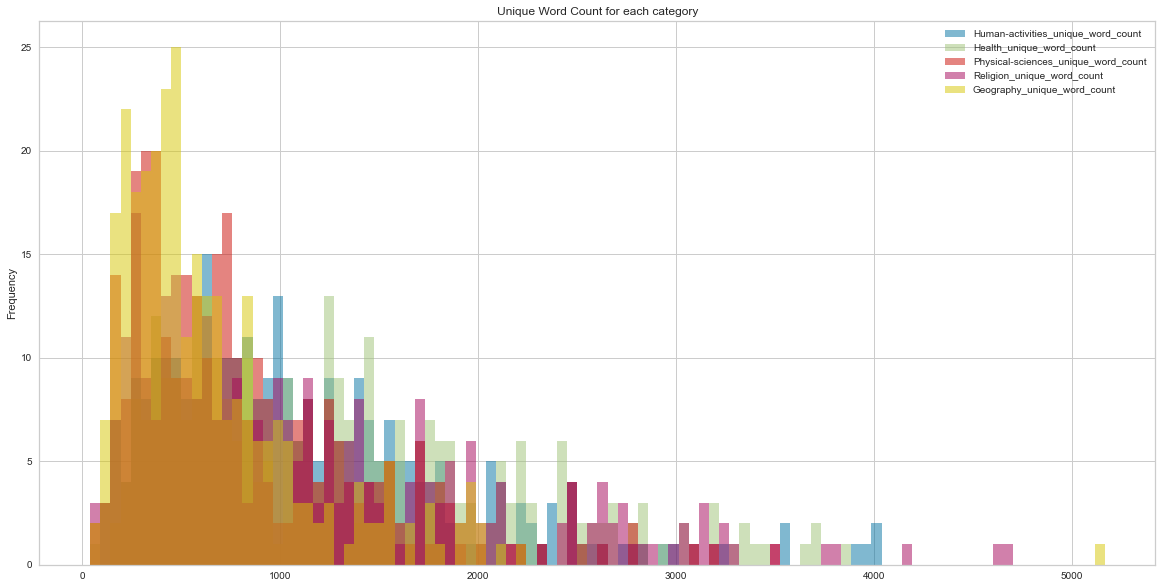

In [10]:
# Visualize word count bar plot with seaborn
plt.figure(figsize=(20, 10))
sns.barplot(x=categories, y=[df_stats[i + '_word_count'].sum() for i in categories], palette='Set2')
plt.title('Word Count for each category')
plt.show()

# Visualize unique word count bar plot with seaborn
plt.figure(figsize=(20, 10))
sns.barplot(x=categories, y=[df_stats[i + '_unique_word_count'].sum() for i in categories], palette='Set2')
plt.title('Unique Word Count for each category')
plt.show()

# Visualize the word count for each category in a box plot
df_stats[[i + '_word_count' for i in categories]].plot.box(figsize=(20, 10), title='Word Count for each category')

# Visualize the unique word count for each category in a box plot
df_stats[[i + '_unique_word_count' for i in categories]].plot.box(figsize=(20, 10), title='Unique Word Count for each category')

# Visualize the word count for each category in a histogram
df_stats[[i + '_word_count' for i in categories]].plot.hist(figsize=(20, 10), title='Word Count for each category', bins=100, alpha=0.5)

# Visualize the unique word count for each category in a histogram
df_stats[[i + '_unique_word_count' for i in categories]].plot.hist(figsize=(20, 10), title='Unique Word Count for each category', bins=100, alpha=0.5)

## Interpret the results: 
bar plor for the word count and unique word count are similar, health has the most unique words, geography has the least unique words. 
box plot for the word count and unique word count are similar, the median is quite similar for all categories.
histogram for the word count and unique word count are similar, the distribution is similar for all categories.

## Calculate the distance between pages in the same category

In [25]:
# prepare the data for the model
# transform the dataframe df so that the shape is (articles, corresponding categories)
df_class = df.T.stack().reset_index()
# drop rows after the first 1500
df_class = df_class.drop(df.index[1500:])
# rename the columns
df_class.columns = ['label', 'category', 'text']
# drop the category column
df_class = df_class.drop(columns=['category'])
# drop duplicates because the same article can be in multiple categories
df_class = df_class.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)
# display the DataFrame
df_class

,label,text
0,Human-activities,art art free encyclopedia jump navigation jump...
1,Human-activities,abiotic stress abiotic stress free encyclopedi...
2,Human-activities,affection affection free encyclopedia jump nav...
3,Human-activities,barter barter free encyclopedia jump navigatio...
4,Human-activities,communication communication free encyclopedia ...
...,...,...
1480,Geography,list country northernmost point list country n...
1481,Geography,western australian border western australian b...
1482,Geography,krasnoyarsk time krasnoyarsk time free encyclo...
1483,Geography,list sovereign state dependent territory list ...


In [26]:
# filter out words that occur less than 5 times
vectorizer = CountVectorizer(analyzer='word', min_df=5)
X = vectorizer.fit_transform(df_class['text'])

# transform the data into a tf-idf matrix
# tf-idf is a statistical measure that evaluates how relevant a word is to a document in a collection of documents
# tf-idf is the product of two statistics, term frequency and inverse document frequency
tfidf = TfidfTransformer()
X_t = tfidf.fit_transform(X)
X_t = X_t.toarray()

In [27]:
# calculate the distance for each category
# we use the cosine distance metric and the jaccard distance metric
# For text mining we use the cosine distance metric
statistics = []

# do the job
for i in categories:
    sub_X = X_t[df_class['label'] == i]

    # compute distance matrix for the selected subset using cosine distance metric
    dm_cos = distance.cdist(sub_X, sub_X, "cosine")

    # append the statistics to the statistics list
    statistics.append([dm_cos.min(), dm_cos.mean(), np.median(dm_cos), dm_cos.max()])

# create a new df with the statistics
statistics_df = pd.DataFrame(statistics, columns=['min', 'mean', 'median', 'max'], index=categories)
statistics_df

,min,mean,median,max
Human-activities,0.0,0.955666,0.969784,0.998636
Health,0.0,0.937190,0.958566,0.997883
Physical-sciences,0.0,0.936992,0.960293,0.998930
Religion,0.0,0.927008,0.949554,0.998759
Geography,0.0,0.946131,0.968145,0.999837


### Interpretation

Generally, the categories have a mean higher than 0.81, which means that the distance between the pages is high.
The category with the highest mean is human activities, followed by health, physical sciences, religion and geography.

The mininum distance is 0.0, which means that the pages are identical. The maximum distance is almost 1.0, which means that the pages are completely different.

tfidf is a count of the number of times a word appears in a document, divided by the total number of words in the document. This is done for every document in the corpus. The words that appear most frequently across all documents are given a lower weight, whereas those that appear less frequently are given a higher weight.

Tfidf is a good measure of how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining.

## Calculate the distance between pages between different categories


In [28]:
# calculate the distance for each category
statistics = []
cat = []
min_dim = []

for i in categories: 
    for j in categories:
        if i > j:
            sub_X = X_t[df_class['label'] == i]
            sub_Y = X_t[df_class['label'] == j]
            # compute distance matrix for the selected subset using cosine distance metric
            dm = distance.cdist(sub_X, sub_Y, "cosine")

            statistics.append([dm.min(), dm.mean(), np.median(dm), dm.max()])
            cat.append(i + ' - ' + j)

# create a new df with the statistics
statistics_diff_df = pd.DataFrame(statistics, columns=['min', 'mean', 'median', 'max'], index=cat)
statistics_diff_df.sort_values('mean')

,min,mean,median,max
Religion - Human-activities,0.177223,0.965592,0.972001,0.999331
Human-activities - Geography,0.352087,0.969108,0.975040,0.999919
Human-activities - Health,0.310059,0.969773,0.975491,0.999274
Religion - Geography,0.466136,0.970900,0.975792,0.999701
Physical-sciences - Health,0.180679,0.971883,0.976866,0.999378
Physical-sciences - Geography,0.213076,0.972464,0.977850,0.999888
Physical-sciences - Human-activities,0.369095,0.973316,0.977865,0.999385
Religion - Health,0.451268,0.973921,0.978598,0.999136
Health - Geography,0.299073,0.974309,0.979055,0.999858
Religion - Physical-sciences,0.412278,0.977285,0.980871,0.999593


## Classify the pages, using the categories as labels

In [29]:
# In this case we have a single label for each article so we can use a supervised learning algorithm
# response vector (y)
y = df_class['label']

# splitting feature matrix X and y into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.3, random_state=1, stratify=y)

In [31]:
# Random forest classifier: works by constructing multiple decision trees at training time and outputting the class 
# that is the mode of the classes. Wisdom of the crowd
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# print classification report
print("Random Forest Classifier model classification report:")
print(metrics.classification_report(y_test, y_pred))


Random Forest Classifier model classification report:
                   precision    recall  f1-score   support

        Geography       0.45      0.78      0.57        88
           Health       0.85      0.83      0.84        90
 Human-activities       0.87      0.30      0.45        90
Physical-sciences       0.81      0.81      0.81        90
         Religion       0.81      0.76      0.78        88

         accuracy                           0.70       446
        macro avg       0.76      0.70      0.69       446
     weighted avg       0.76      0.70      0.69       446



In [32]:
# SVM finds the hyperplane that maximizes the margin between the two classes.
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# print classification report
print("SVM model classification report:")
print(metrics.classification_report(y_test, y_pred))

SVM model classification report:
                   precision    recall  f1-score   support

        Geography       0.79      0.86      0.83        88
           Health       0.90      0.84      0.87        90
 Human-activities       0.68      0.83      0.75        90
Physical-sciences       0.94      0.86      0.90        90
         Religion       0.92      0.77      0.84        88

         accuracy                           0.83       446
        macro avg       0.85      0.83      0.84       446
     weighted avg       0.85      0.83      0.84       446



In [33]:
# KNN: finding the k nearest neighbors of a data point, taking the majority vote of their labels as the label of the data point.
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

# print classification report
print("KNN model classification report:")
print(metrics.classification_report(y_test, y_pred))

KNN model classification report:
                   precision    recall  f1-score   support

        Geography       0.67      0.84      0.75        88
           Health       0.86      0.88      0.87        90
 Human-activities       0.83      0.71      0.77        90
Physical-sciences       0.88      0.86      0.87        90
         Religion       0.85      0.76      0.80        88

         accuracy                           0.81       446
        macro avg       0.82      0.81      0.81       446
     weighted avg       0.82      0.81      0.81       446



In [43]:
# kfold is better than train_test_split because it uses all the data for training and testing
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# create a list of models
models = [RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0), svm.SVC(), KNeighborsClassifier(n_neighbors=3)]

# create a list of model names
model_names = ['Random Forest Classifier', 'SVM', 'KNN']

# create a list of accuracies
accuracies = []

# define y
y = df_class['label']

# iterate over the models
for model in models:
    # create a list to store the accuracies of each fold
    acc = []
    # iterate over the folds
    for train_index, test_index in kf.split(X_t):
        # split the data into train and test
        X_train, X_test = X_t[train_index], X_t[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # train the model
        model.fit(X_train, y_train)
        # make predictions
        y_pred = model.predict(X_test)
        # calculate the accuracy
        acc.append(metrics.accuracy_score(y_test, y_pred))
    # append the mean accuracy of the model to the accuracies list
    accuracies.append(np.mean(acc))

# create a new df with the accuracies
accuracies_df = pd.DataFrame(accuracies, columns=['accuracy'], index=model_names)
accuracies_df
# we dont need precision, recall and f1-score because the dataset is balanced.

,accuracy
Random Forest Classifier,0.725943
SVM,0.866008
KNN,0.827648


### Interpretation of the results: 

The classification is not very good, because the categories are not very well defined. 

For example, the category "Human activities" includes a lot of different topics, such as "Sports", "Music", "Arts", "Literature", "Food", "Fashion", "Games", etc... 

The category "Health" includes a lot of different topics, such as "Diseases", "Medicine", "Healthcare", "Nutrition", "Fitness", "Mental health", etc... 

The category "Physical sciences" includes a lot of different topics, such as "Physics", "Chemistry", "Biology", "Astronomy", "Geology", "Mathematics", etc... 

The category "Religion" includes a lot of different topics, such as "Christianity", "Islam", "Judaism", "Hinduism", "Buddhism", "Sikhism", "Atheism", etc... 

The category "Geography" includes a lot of different topics, such as "Countries", "Cities", "Mountains", "Rivers", "Lakes", "Oceans", "Continents", etc.. 

## Check the wikipedia categorization or any deviations with a clustering method and in this case analyze the probable causes

In [38]:
# Clustering is an unsupervised machine learning method 
# Kmeans: the algorithm randomly assigns each data point to a cluster, then finds the centroid of each cluster.
def kmeans_clusters(X, k, print_silhouette_values):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = KMeans(n_clusters=k).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette Coefficient: {silhouette_score(X, km.labels_):.3f}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]}"
            )
    return km, km.labels_

In [39]:
# model = KMeans(random_state=42)

# elb_visualizer = KElbowVisualizer(model, k=(2,11))
# elb_visualizer.fit(X_t)    
# elb_visualizer.show()      

In [40]:
# generate clusters using the optimal number of clusters
docs = df_class["text"].values
k = 5
clustering, cluster_labels = kmeans_clusters(X_t, k,print_silhouette_values=True)
df_clusters = pd.DataFrame({"text": docs,"cluster": cluster_labels})

# compare the clusters with the original labels
df_clusters["label"] = df_class["label"]
df_clusters

# create a new df with the clusters
new_df = df_clusters.groupby(["cluster", "label"]).size().reset_index(name="count")
new_df

For n_clusters = 5
Silhouette Coefficient: 0.015
Silhouette values:
    Cluster 0: Size:230
    Cluster 1: Size:188
    Cluster 2: Size:193
    Cluster 3: Size:47
    Cluster 4: Size:827


,cluster,label,count
0,0,Geography,3
1,0,Health,45
2,0,Human-activities,3
3,0,Physical-sciences,179
4,1,Health,4
5,1,Human-activities,7
6,1,Religion,177
7,2,Geography,5
8,2,Health,174
9,2,Human-activities,10


## Interpretation of the results:
The biggest cluster has no specific categories 

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

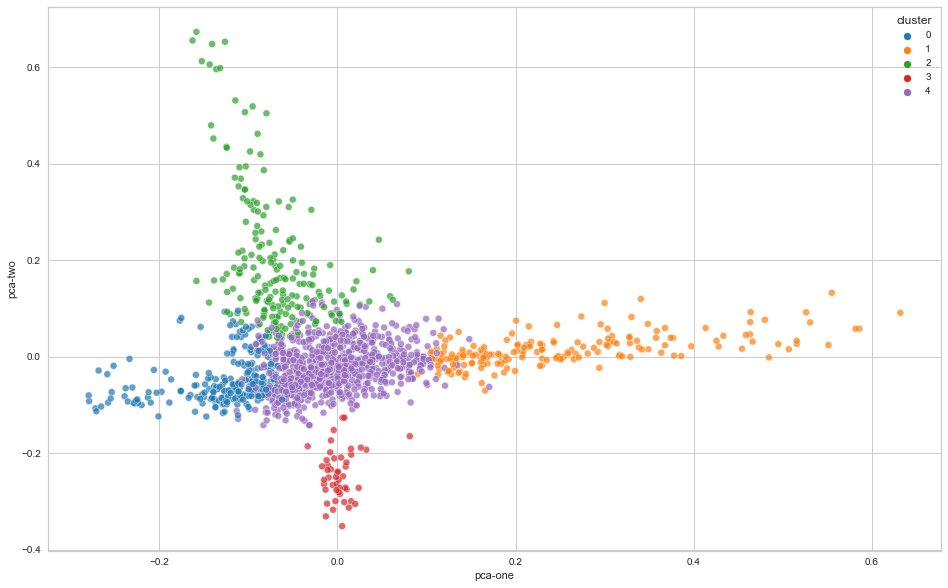

In [41]:
# Visualize the kmeans clusters of documents using PCA with 2 components with the new clusters
# PCA works 
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_t)
df_pca = pd.DataFrame({
    "pca-one": pca_result[:, 0],
    "pca-two": pca_result[:, 1],
    "cluster": cluster_labels
})
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="cluster",
    palette=sns.color_palette("tab10", k),
    data=df_pca,
    legend="full",
    alpha=0.7
)


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

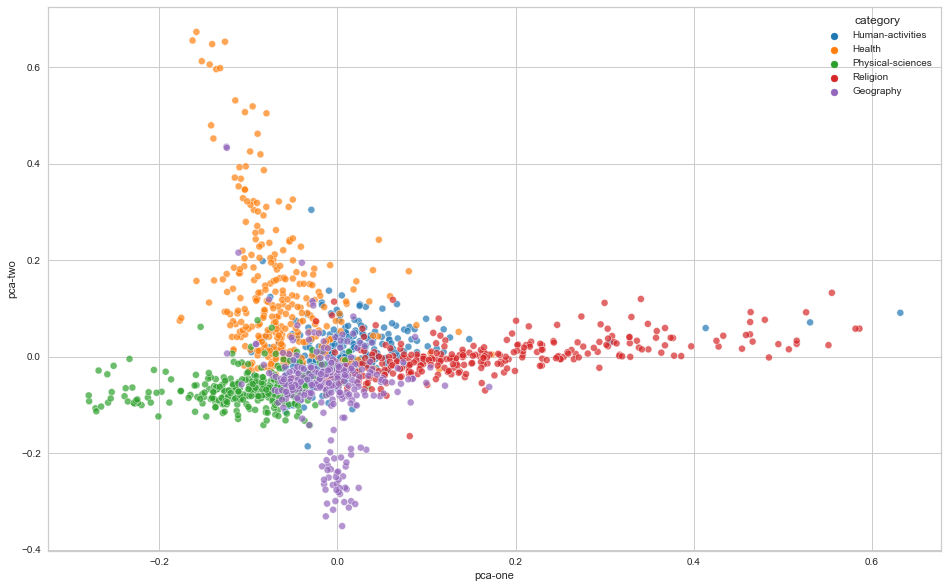

In [42]:
# Visualize the documents of the categories using PCA with 2 components with the original labels
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_t)
df_pca = pd.DataFrame({
    "pca-one": pca_result[:, 0],
    "pca-two": pca_result[:, 1],
    "category": df_class["label"]
})
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="category",
    palette=sns.color_palette("tab10", 5),
    data=df_pca,
    legend="full",
    alpha=0.7
)

PCA is finding the principal components of the dataset, which are the directions in which the data varies the most. It then projects the data onto the first few principal components, which are the ones that explain the most variance in the data.

### Interpretation of the results: 
For the project we had to choose 5 categories and 300 articles for each category, so we had to choose widly fenced categories. Hence, we could see in the distance matrix that the categories share a lot of articles because articles can belong to more than one category. There is one cluster which is the "Human activities" category, which is the biggest cluster. The other clusters are smaller and they are the other categories. Human activities is the biggest cluster because it is difficult to define the category, it is a very wide category. The other categories are smaller because they are more defined.